In [1]:
import copy
import itertools
import pandas as pd
import numpy as np

import bpmn_python.bpmn_diagram_layouter as layouter
import bpmn_python.bpmn_diagram_visualizer as visualizer
import bpmn_python.bpmn_diagram_rep as diagram

In [2]:
relations = np.empty((8,8,))
relations[:] = np.nan

relations[0,1]=0.86
relations[1,0]=-0.86
relations[1,2]=0.75
relations[2,1]=-0.75
relations[1,3]=0.75
relations[3,1]=-0.75
relations[1,1]=0.75
#a[1,1]=-0.8
relations[2,3]=0
relations[3,2]=0
relations[2,5]=0.75
relations[5,2]=-0.75

relations[3,4]=0.66
relations[4,3]=-0.66
relations[3,5]=0.5
relations[5,3]=-0.5

relations[7,4]=-0.66
relations[4,7]=0.66
relations[6,5]=0
relations[5,6]=0
relations[7,5]=-0.8
relations[5,7]=0.8

relations

array([[  nan,  0.86,   nan,   nan,   nan,   nan,   nan,   nan],
       [-0.86,  0.75,  0.75,  0.75,   nan,   nan,   nan,   nan],
       [  nan, -0.75,   nan,  0.  ,   nan,  0.75,   nan,   nan],
       [  nan, -0.75,  0.  ,   nan,  0.66,  0.5 ,   nan,   nan],
       [  nan,   nan,   nan, -0.66,   nan,   nan,   nan,  0.66],
       [  nan,   nan, -0.75, -0.5 ,   nan,   nan,  0.  ,  0.8 ],
       [  nan,   nan,   nan,   nan,   nan,  0.  ,   nan,   nan],
       [  nan,   nan,   nan,   nan, -0.66, -0.8 ,   nan,   nan]])

In [3]:
loops = np.empty((8,8,))
loops[:] = np.nan

loops[5,6]=0.75
loops

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan, 0.75,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])

In [4]:
T_0 = ['a','b','c','d','e','f','g','h']
T_1 = ['a']#only positive in row
T_n = ['h']#only negative in row
tasks = ['a','b','c','d','e','f','g','h']

In [6]:
def negativeInRow(array, start):
    for i, x in enumerate(array):
        if x <0 and i != start:
            return i
def positiveInRow(array, start):
    for i, x in enumerate(array):
        if x > 0 and i != start:
            return i

In [7]:
def nextNoNanIndex(array, start):
    nextItems = array[start+1:]
    for i, x in enumerate(nextItems):
        if x != np.nan:
            return 1 + start + i

In [8]:
Xl_a = []
Xl_b = []
Xl_c = []
P_d = []
P_e = []
L_1 = []
L_2 = []

for task in range(len(T_0)):
    
    x = task    
    
    #that's L_1
    if relations[x,x] > 0: 
        aa = negativeInRow(relations[x],x) #a->bb (minus w rzędzie b)
        cc = positiveInRow(relations[x],x)#bb->c (plus w b)
        if not aa+1:
            print('todo_a')##L_1.append(())
        elif not cc+1:
            print('todo_c')##L_1.append(())
        else:
            L_1.append((T_0[aa],T_0[x],T_0[cc])) 
        
    y = nextNoNanIndex(relations[x],0)
    if not y :
        continue 
    
    #that's L_2
    for i in range(len(T_0)-y):
        a = y+i
        if loops[x,a] > 0: 
            aba = negativeInRow(relations[x],x) #a->bcb (minus w rzędzie b)
            cbc = positiveInRow(relations[x],x)#bcb->d (plus w b)
            L_2.append(( T_0[aba],(T_0[x],T_0[a],T_0[x]), T_0[cbc]))

    #that's A 
                       
    for i in range(len(T_0)-y):
        a = y+i
        if relations[x,a] > 0 and relations[a,x] < 0: 
            Xl_a.append((T_0[x],T_0[a])) #A is ok
        
    for i in range(len(T_0)-y):
        a = y+i
        z = nextNoNanIndex(relations[x],a)
        if not (a and z):
            continue  
        
        #that's B,C
        if np.all(relations[x,a] > 0 and relations[x,z] > 0 and relations[a,z] == np.nan):
            Xl_b.append((T_0[x],(T_0[a],T_0[z]))) 
        if np.all(relations[x,a] < 0 and relations[x,z] < 0 and relations[a,z] == np.nan):
            Xl_c.append(((T_0[a],T_0[z]),T_0[x])) #C is ok
        
        #that's D,E
        if np.all(relations[x,a]> 0 and relations[x,z] > 0 and relations[a,z] == 0):
            P_d.append((T_0[x],(T_0[a], T_0[z]))) #k
        if np.all(relations[x,a] < 0 and relations[x,z] < 0 and relations[a,z] == 0):
            P_e.append(((T_0[a], T_0[z]),T_0[x])) 

In [9]:
Yl = copy.deepcopy(Xl_a)
print(Yl)



for bit in Xl_b:    
    Yl.remove((bit[0], bit[1][0]))
    Yl.remove((bit[0], bit[1][1]))
    #Yl.append(bit)

for bit in Xl_c:    
    Yl.remove((bit[0][0], bit[1]))
    Yl.remove((bit[0][1], bit[1]))
    #Yl.append(bit)

for bit in P_d:    
    Yl.remove((bit[0], bit[1][0]))
    Yl.remove((bit[0], bit[1][1]))
        #Yl.append(bit)

for bit in P_e:    
    Yl.remove((bit[0][0], bit[1]))
    Yl.remove((bit[0][1], bit[1]))
    #Yl.append(bit)
    
for bit in L_1:
    if ((bit[0], bit[1])) in Yl:
        Yl.remove((bit[0], bit[1]))
    if ((bit[1], bit[2])) in Yl:
        Yl.remove((bit[1], bit[2]))
    #Yl.append(bit)


for bit in L_2:
    if ((bit[0], bit[1][0])) in Yl:
        Yl.remove((bit[0], bit[1][0]))
    if ((bit[0], bit[1][1])) in Yl:
        Yl.remove((bit[0], bit[1][1]))
    if ((bit[1][0], bit[2])) in Yl:
        Yl.remove((bit[1][0], bit[2]))

    #Yl.append(bit)
    
print(Yl)
print(Xl_b)
print(Xl_c)
print(P_d)
print(P_e) 
print(L_1)
print(L_2)

[('a', 'b'), ('b', 'c'), ('b', 'd'), ('c', 'f'), ('d', 'e'), ('d', 'f'), ('e', 'h'), ('f', 'h')]
[('d', 'e'), ('e', 'h')]
[]
[]
[('b', ('c', 'd'))]
[(('c', 'd'), 'f')]
[('a', 'b', 'c')]
[('c', ('f', 'g', 'f'), 'h')]


In [10]:
bpmn_graph = diagram.BpmnDiagramGraph()
bpmn_graph.create_new_diagram_graph(diagram_name="diagram1")
process_id = bpmn_graph.add_process_to_diagram()
output_png_file = "diagram"
output_file_with_di = "output.xml"
output_directory = "./"

In [11]:
[start_id,_] = bpmn_graph.add_start_event_to_diagram(process_id, start_event_name="start_event", )

xors_fork = []
for n in Xl_b:
    xors_fork.append((bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_fork"))[0])
xors_fork_l1 = []
for n in L_1:
    xors_fork_l1.append((bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_fork"))[0])
xors_fork_l2 = []
for n in L_2:
    xors_fork_l2.append((bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_fork"))[0])

ands_fork = []
for t in P_d:
    ands_fork.append((bpmn_graph.add_parallel_gateway_to_diagram(process_id, gateway_name="parallel_gate_fork"))[0])

all_tasks = []
for task in tasks: 
    all_tasks.append((bpmn_graph.add_task_to_diagram(process_id, task_name=str(task)))[0])
    #print(all_tasks)

xors_join = []
for i in Xl_c:
    xors_join.append((bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_join"))[0])
xors_join_l1 = []
for n in L_1:
    xors_join_l1.append((bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_join"))[0])
xors_join_l2 = []
for n in L_2:
    xors_join_l2.append((bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_join"))[0])

ands_join = []                     
for k in P_e:
    ands_join.append((bpmn_graph.add_parallel_gateway_to_diagram(process_id, gateway_name="parallel_gate_join"))[0])

[end_id, _] = bpmn_graph.add_end_event_to_diagram(process_id, end_event_name="end_event", )



In [12]:
if len(T_1)>1:
    [first_xor,_] = bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_fork")
    #start_id -> XOR
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=start_id, target_ref_id=first_xor)
    for elem in T_1:
        bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=first_xor, target_ref_id=all_tasks[T_0.index(elem)] )
        #XOR -> bit
else:
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=start_id, target_ref_id=all_tasks[T_0.index(T_1[0])]) #start_event -> T_1[0]

for bits in T_n:
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(bits)], target_ref_id=end_id )#bit -> end_event
    

for num, B in enumerate(Xl_b):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(B[0])], target_ref_id=xors_fork[num] )#B[0] -> XOR 
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_fork[num], target_ref_id=all_tasks[T_0.index(B[1][0])] )#XOR -> B[1][0]
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_fork[num], target_ref_id=all_tasks[T_0.index(B[1][1])] )#XOR -> B[1][1]
    
for num, C in enumerate(Xl_c):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(C[0][0])], target_ref_id=xors_join[num] )#C[0][0] -> XOR
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(C[0][1])], target_ref_id=xors_join[num] )#C[0][1] -> XOR
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_join[num], target_ref_id=all_tasks[T_0.index(C[1])] )#XOR -> C[1]
    
for num, D in enumerate(P_d):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(D[0])], target_ref_id=ands_fork[num] )#D[0] -> AND 
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=ands_fork[num], target_ref_id=all_tasks[T_0.index(D[1][0])] )#AND -> D[1][0]
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=ands_fork[num], target_ref_id=all_tasks[T_0.index(D[1][1])] )#AND -> D[1][1]
    
for num, E in enumerate(P_e):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(E[0][0])], target_ref_id=ands_join[num] )#E[0][0] -> AND
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(E[0][1])], target_ref_id=ands_join[num] )#E[0][1] -> AND
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=ands_join[num], target_ref_id=all_tasks[T_0.index(E[1])] )#AND -> E[1]        

    
for A in Yl:      
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(A[0])], target_ref_id=all_tasks[T_0.index(A[1])] )#A[0] -> A[1]
    
    
for num, L in enumerate(L_1):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(L[0])], target_ref_id=xors_join_l1[num] )#A -> XOR
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(L[1])], target_ref_id=xors_fork_l1[num] )#L -> XOR 
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_join_l1[num], target_ref_id=all_tasks[T_0.index(L[1])] )#XOR -> L
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_fork_l1[num], target_ref_id=xors_join_l1[num] )#XOR -> XOR 
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_fork_l1[num], target_ref_id=all_tasks[T_0.index(L[2])] )#XOR -> C

for num, L in enumerate(L_2):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(L[0])], target_ref_id=xors_join_l2[num] )#A -> XOR
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(L[1][0])], target_ref_id=xors_fork_l2[num] )#B -> XOR 
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_join_l2[num], target_ref_id=all_tasks[T_0.index(L[1][0])] )#XOR -> B
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_fork_l2[num], target_ref_id=all_tasks[T_0.index(L[1][1])] )#XOR -> C    
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(L[1][1])], target_ref_id=xors_join_l2[num] )#C -> XOR
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_fork_l2[num], target_ref_id=all_tasks[T_0.index(L[2])] )#XOR -> D     

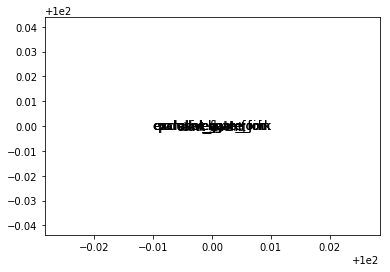

In [15]:
#('c', ('f', 'g', 'f'), 'h')
#layouter.generate_layout(bpmn_graph)
#bpmn_python.bpmn_diagram_layouter.insert_into_grid(grid, 8, col, node_id)
bpmn_graph.export_xml_file(output_directory, output_file_with_di)
visualizer.bpmn_diagram_to_png(bpmn_graph, output_directory + output_png_file)
visualizer.visualize_diagram(bpmn_graph)